In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import time
import unittest
import math
import gym
import numpy as np

#env = gym.make('CartPole-v0')


env = gym.make('CartPole-v0')
env.reset()


# Qlearner for CartPole
class QLearner():
    def __init__(self, env):
        self.env = env
        self.epsilon_start = 1. # 1-epsilon probability of selecting best action. The epsilon is the greedy
        self.epsilon_end = 0.01 # final epsilon value
        self.epsilon_decay = 500 # steps before epsilon reaches epsilon_end
        self.epsilon_step = 0 #step tracker
        self.alpha = 0.1
        self.gamma = 0.99
        
        # get initial state, divide continuous states into discrete bins
#         self.bins = [np.linspace(env.observation_space.low[i], env.observation_space.high[i], 7) for i in range(4)]
        self.bins = []
        #self.bins.append(np.linspace(-2.4, 2.4, 5))
        #self.bins.append(np.linspace(-0.5, 0.5, 5))
        self.bins.append(np.linspace(-2.4, 2.4, 1))
        self.bins.append(np.linspace(-0.5, 0.5, 1))
        self.bins.append(np.linspace(-41.8, 41.8, 5))
        self.bins.append(np.linspace(-math.radians(50), math.radians(50), 5))
        self.reset()
        
        #initialize Q
#         self.Q = np.zeros((20, 20, 20, 20, 2))
        self.Q = {}
#         print(self.bins)

        self.episode_durations = []
        
    
    def getQ(self, s, action=None):
#         return self.Q[s[0], s[1], s[2], s[3], action]
#         print('getQ:', s, action)
        if not s in self.Q:
            self.Q[s] = [0, 0]

        if action is not None:
            return self.Q[s][action]
        else:
            return self.Q[s]
    
    
    def setQ(self, s, s_plus1, action, r):
#         print("Setting Q: ")
#         print("s: ", s, "s_plus1: ", s_plus1, " action: ", action, " r: ", r)
#         print("s:", s[0], s[1], s[2], s[3], "action: ", action)

        q = self.getQ(s, action)
    
        print "old q is ", q 
        
        
        
        max_q_splus1 = np.max(self.getQ(s_plus1))
        
        print "max q is ", max_q_splus1 
        
        print "R is ", r 
        
#         print("q: ", q, " max_q_splus1: ", max_q_splus1)
        new_q = q + self.alpha * (r + self.gamma * max_q_splus1 - q)
    
        print "new_q is:", new_q

        self.Q[s][action] = new_q
        
    def printQ(self):
        for s in self.Q:
            print(s, self.Q[s])
    
    def get_best_action(self, s):
        return np.argmax(self.getQ(s))
    
    def get_epsilon(self):
        return 1.0
#         return max(self.epsilon_end, self.epsilon_start + 
#                       self.epsilon_step / self.epsilon_decay * (self.epsilon_end - self.epsilon_start))
    
    def get_training_action(self):
        epsilon = self.get_epsilon()

        if np.random.rand() >= epsilon:
            action = self.get_best_action(self.s)
        else:
            action = self.env.action_space.sample()
        
        self.epsilon_step += 1
        return action
    
    def reset(self):
        s = env.reset()
        self.s = tuple([np.asscalar(np.digitize(s[i], self.bins[i])) for i in range(4)])
    
    def step(self, action, training=False, step=0):
        observation, r, done, _ = self.env.step(action)
#         print("s0:", self.s)
#         print("s1:", s_plus1)
#         print("velocity:", s_plus1[3])
        s_plus1 = tuple([np.asscalar(np.digitize(observation[i], self.bins[i])) for i in range(4)])
        
        #if training and done and step < 200:
            #r = -100
        
        self.setQ(self.s, s_plus1, action, r)
            
        self.s = s_plus1
        
        return r, done
    
    def train(self, nb_episodes=2):
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_training_action()
                r, done = self.step(action, training=True, step=episode_reward+1)
                                
                episode_reward += r
                
                if done:
                    break;
            self.episode_durations.append(episode_reward + 1)
#             self.plot_durations()            
#             print("Episode %d reward: %d epsilon: %.4f" % (episode, episode_reward, self.get_epsilon()))

    def run(self):
        self.reset()
        self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_best_action(self.s)
            r, done = self.step(action)
            episode_reward += r
#             time.sleep(0.1)
            if done:
                self.env.close()
                break;
        
        self.env.render(close=True)
        print("Total Reward: ", episode_reward)
        
class TestQlearner(unittest.TestCase):
    def setUp(self):
        env = gym.make('CartPole-v0')
        self.qlearner = QLearner(env)
        self.qlearner.alpha = 0.01
        self.qlearner.gamma = 0.99

    def test_setQ(self):
        self.qlearner.setQ((4, 4, 4, 4), (4, 4, 4, 5), 1, 1)
        print(self.qlearner.Q)
        self.assertEqual(self.qlearner.getQ((4, 4, 4, 4), 1), 0.01)
        
        print(' ')
        self.qlearner.setQ((4, 4, 4, 5), (4, 4, 4, 4), 0, 1)
        print(self.qlearner.Q)
        newQ = self.qlearner.getQ((4, 4, 4, 5), 0)
        self.assertEqual(newQ, 0.010099)
        
        
    def runTest(self):
        self.test_setQ()
        

tester = TestQlearner()
tester.debug()

[2018-02-03 15:14:31,463] Making new env: CartPole-v0
[2018-02-03 15:14:31,482] Making new env: CartPole-v0


old q is  0
max q is  0
R is  1
new_q is: 0.01
{(4, 4, 4, 5): [0, 0], (4, 4, 4, 4): [0, 0.01]}
 
old q is  0
max q is  0.01
R is  1
new_q is: 0.010099
{(4, 4, 4, 5): [0.010099, 0], (4, 4, 4, 4): [0, 0.01]}


[2018-02-03 15:14:33,671] Making new env: CartPole-v0


old q is  0
max q is  0
R is  1.0
new_q is: 0.1
old q is  0
max q is  0.1
R is  1.0
new_q is: 0.1099
old q is  0
max q is  0.1
R is  1.0
new_q is: 0.1099
old q is  0.1
max q is  0.1099
R is  1.0
new_q is: 0.2008801
old q is  0
max q is  0.1099
R is  1.0
new_q is: 0.1108801
old q is  0.1099
max q is  0.1108801
R is  1.0
new_q is: 0.2098871299
old q is  0.1108801
max q is  0.2098871299
R is  1.0
new_q is: 0.22057091586
old q is  0.22057091586
max q is  0
R is  1.0
new_q is: 0.298513824274
old q is  0
max q is  0.298513824274
R is  1.0
new_q is: 0.129552868603
old q is  0.298513824274
max q is  0.129552868603
R is  1.0
new_q is: 0.381488175838
old q is  0.129552868603
max q is  0.129552868603
R is  1.0
new_q is: 0.229423315735
old q is  0.229423315735
max q is  0.381488175838
R is  1.0
new_q is: 0.344248313569
old q is  0.2098871299
max q is  0.2008801
R is  1.0
new_q is: 0.30878554681
old q is  0.1099
max q is  0.2008801
R is  1.0
new_q is: 0.2187971299
old q is  0.2008801
max q is  0.21

old q is  1.23134004436
max q is  1.90369848875
R is  1.0
new_q is: 1.39667219031
old q is  1.39667219031
max q is  0.1
R is  1.0
new_q is: 1.36690497128
old q is  0
max q is  0.920424378934
R is  1.0
new_q is: 0.191122013514
old q is  0.871007577084
max q is  1.24254832812
R is  1.0
new_q is: 1.00691910386
old q is  1.01959605261
max q is  0.730681007803
R is  1.0
new_q is: 1.08997386713
old q is  0.730681007803
max q is  1.24254832812
R is  1.0
new_q is: 0.880625191507
old q is  1.08997386713
max q is  1.24254832812
R is  1.0
new_q is: 1.2039887649
old q is  1.2039887649
max q is  0.880625191507
R is  1.0
new_q is: 1.27077178237
old q is  0.880625191507
max q is  1.27077178237
R is  1.0
new_q is: 1.01836907881
old q is  1.24254832812
max q is  1.00691910386
R is  1.0
new_q is: 1.31797848659
old q is  1.00691910386
max q is  1.31797848659
R is  1.0
new_q is: 1.13670706365
old q is  1.31797848659
max q is  1.13670706365
R is  1.0
new_q is: 1.39871463724
old q is  0.920424378934
max q i

max q is  3.17959936695
R is  1.0
new_q is: 2.93177190242
old q is  3.17959936695
max q is  3.17959936695
R is  1.0
new_q is: 3.27641976758
old q is  3.27641976758
max q is  2.96946174857
R is  1.0
new_q is: 3.34275450393
old q is  2.45580661479
max q is  0.69271765581
R is  1.0
new_q is: 2.37880500124
old q is  0
max q is  3.1713268824
R is  1.0
new_q is: 0.413961361358
old q is  2.8389350289
max q is  0.69271765581
R is  1.0
new_q is: 2.72362057394
old q is  0.413961361358
max q is  3.1713268824
R is  1.0
new_q is: 0.78652658658
old q is  3.1713268824
max q is  3.1713268824
R is  1.0
new_q is: 3.26815555552
old q is  2.52199349644
max q is  2.52199349644
R is  1.0
new_q is: 2.61947150295
old q is  2.61947150295
max q is  2.40835889063
R is  1.0
new_q is: 2.69595188282
old q is  2.39748756653
max q is  2.69595188282
R is  1.0
new_q is: 2.52463804627
old q is  2.47198932853
max q is  2.69595188282
R is  1.0
new_q is: 2.59168963207
old q is  2.69595188282
max q is  2.69595188282
R is  1

old q is  0.407571627045
max q is  4.2311326545
R is  1.0
new_q is: 0.885696597135
old q is  4.2311326545
max q is  4.2311326545
R is  1.0
new_q is: 4.32690152184
old q is  3.66520169667
max q is  4.32690152184
R is  1.0
new_q is: 3.82704477767
old q is  4.32690152184
max q is  4.32690152184
R is  1.0
new_q is: 4.42257462032
old q is  3.82704477767
max q is  4.42257462032
R is  1.0
new_q is: 3.98217518731
old q is  3.98217518731
max q is  4.42257462032
R is  1.0
new_q is: 4.12179255599
old q is  4.42257462032
max q is  4.42257462032
R is  1.0
new_q is: 4.5181520457
old q is  4.12179255599
max q is  4.5181520457
R is  1.0
new_q is: 4.25691035292
old q is  3.8441877747
max q is  4.41836790422
R is  1.0
new_q is: 3.99718741975
old q is  4.01049882593
max q is  3.99718741975
R is  1.0
new_q is: 4.10517049789
old q is  3.99718741975
max q is  4.41836790422
R is  1.0
new_q is: 4.13488710029
old q is  4.41836790422
max q is  3.8307917215
R is  1.0
new_q is: 4.45577949423
old q is  3.830791721

old q is  5.88325045042
max q is  5.88325045042
R is  1.0
new_q is: 5.97736719997
old q is  5.97736719997
max q is  5.77071809181
R is  1.0
new_q is: 6.05093157107
old q is  4.37127328347
max q is  2.97303621587
R is  1.0
new_q is: 4.3284765405
old q is  2.97303621587
max q is  5.1845232011
R is  1.0
new_q is: 3.28900039119
old q is  5.1845232011
max q is  5.1845232011
R is  1.0
new_q is: 5.2793386779
old q is  5.2793386779
max q is  5.2793386779
R is  1.0
new_q is: 5.37405933922
old q is  4.37462593672
max q is  4.23935883453
R is  1.0
new_q is: 4.45685986767
old q is  2.9104436882
max q is  1.34736899522
R is  1.0
new_q is: 2.85278884991
old q is  1.34736899522
max q is  2.17565778694
R is  1.0
new_q is: 1.5280222166
old q is  0.545433851644
max q is  0.499473289695
R is  1.0
new_q is: 0.640338322159
old q is  0.499473289695
max q is  5.37405933922
R is  1.0
new_q is: 1.08155783531
old q is  5.37405933922
max q is  5.37405933922
R is  1.0
new_q is: 5.46868527988
old q is  5.468685279

old q is  7.5021662555
max q is  7.5194078108
R is  1.0
new_q is: 7.59637100322
old q is  8.0356469204
max q is  8.0356469204
R is  1.0
new_q is: 8.12761127348
old q is  8.12761127348
max q is  7.83234658261
R is  1.0
new_q is: 8.19025245781
old q is  7.83234658261
max q is  8.19025245781
R is  1.0
new_q is: 7.95994691767
old q is  8.19025245781
max q is  7.95994691767
R is  1.0
new_q is: 8.25926195688
old q is  7.95994691767
max q is  8.25926195688
R is  1.0
new_q is: 8.08161915964
old q is  8.25926195688
max q is  8.08161915964
R is  1.0
new_q is: 8.33341605799
old q is  8.08161915964
max q is  8.33341605799
R is  1.0
new_q is: 8.19846543341
old q is  8.33341605799
max q is  8.19846543341
R is  1.0
new_q is: 8.4117225301
old q is  5.97782009917
max q is  7.59637100322
R is  1.0
new_q is: 6.23207881857
old q is  7.5194078108
max q is  8.19846543341
R is  1.0
new_q is: 7.67911510762
old q is  6.23207881857
max q is  7.67911510762
R is  1.0
new_q is: 6.46910333237
old q is  7.6791151076

old q is  9.28081288557
max q is  9.28081288557
R is  1.0
new_q is: 9.37153207268
old q is  9.37153207268
max q is  9.37153207268
R is  1.0
new_q is: 9.46216054061
old q is  8.73268310654
max q is  9.46216054061
R is  1.0
new_q is: 8.8961686894
old q is  7.99596622808
max q is  8.893522133
R is  1.0
new_q is: 8.17682829644
old q is  8.893522133
max q is  8.19846543341
R is  1.0
new_q is: 8.91581799761
old q is  6.70553889057
max q is  9.46216054061
R is  1.0
new_q is: 7.07173889503
old q is  8.8961686894
max q is  8.19846543341
R is  1.0
new_q is: 8.91819989837
old q is  8.19846543341
max q is  8.91581799761
R is  1.0
new_q is: 8.36128487184
old q is  8.12933497105
max q is  8.91581799761
R is  1.0
new_q is: 8.29906745571
old q is  8.91581799761
max q is  8.91581799761
R is  1.0
new_q is: 9.00690217961
old q is  8.29906745571
max q is  9.00690217961
R is  1.0
new_q is: 8.46084402592
old q is  8.46084402592
max q is  8.17682829644
R is  1.0
new_q is: 8.52426562468
old q is  8.1768282964

max q is  6.69046643972
R is  1.0
new_q is: 6.26403734943
old q is  6.69046643972
max q is  7.23861130895
R is  1.0
new_q is: 6.83804231533
old q is  7.23861130895
max q is  7.23861130895
R is  1.0
new_q is: 7.33137269764
old q is  7.33137269764
max q is  7.33137269764
R is  1.0
new_q is: 7.42404132495
old q is  7.42404132495
max q is  7.42404132495
R is  1.0
new_q is: 7.51661728362
old q is  7.08231887829
max q is  7.51661728362
R is  1.0
new_q is: 7.21823210154
old q is  7.21823210154
max q is  7.51661728362
R is  1.0
new_q is: 7.34055400246
old q is  7.31806542899
max q is  9.55501957837
R is  1.0
new_q is: 7.63220582435
old q is  7.63220582435
max q is  6.83804231533
R is  1.0
new_q is: 7.64595143113
old q is  6.83804231533
max q is  7.51661728362
R is  1.0
new_q is: 6.99838319488
old q is  7.34055400246
max q is  6.99838319488
R is  1.0
new_q is: 7.39933853851
old q is  6.99838319488
max q is  7.51661728362
R is  1.0
new_q is: 7.14268998647
old q is  7.51661728362
max q is  7.5166

new_q is: 7.5340211006
old q is  7.5340211006
max q is  6.94750944714
R is  1.0
new_q is: 7.56842242581
old q is  5.60617769376
max q is  4.98661298439
R is  1.0
new_q is: 5.63923460984
old q is  4.98661298439
max q is  6.94750944714
R is  1.0
new_q is: 5.27575512122
old q is  6.94750944714
max q is  7.56842242581
R is  1.0
new_q is: 7.10203232258
old q is  7.39025214908
max q is  7.56842242581
R is  1.0
new_q is: 7.50050075432
old q is  7.50050075432
max q is  7.76630901618
R is  1.0
new_q is: 7.61931527149
old q is  6.80137142993
max q is  7.76630901618
R is  1.0
new_q is: 6.99009887953
old q is  7.76630901618
max q is  7.76630901618
R is  1.0
new_q is: 7.85854270716
old q is  7.85854270716
max q is  8.43730043717
R is  1.0
new_q is: 8.00798117972
old q is  8.43730043717
max q is  8.43730043717
R is  1.0
new_q is: 8.52886313673
old q is  8.52886313673
max q is  8.52886313673
R is  1.0
new_q is: 8.6203342736
old q is  8.6203342736
max q is  8.6203342736
R is  1.0
new_q is: 8.711713939

R is  1.0
new_q is: 2.51517737035
old q is  4.78352981922
max q is  9.8913672151
R is  1.0
new_q is: 5.38442219159
old q is  9.81036776886
max q is  8.76097777774
R is  1.0
new_q is: 9.79666779197
old q is  8.76097777774
max q is  9.8913672151
R is  1.0
new_q is: 8.96412535426
old q is  9.79666779197
max q is  8.96412535426
R is  1.0
new_q is: 9.80444942284
old q is  8.06980541154
max q is  8.52769374874
R is  1.0
new_q is: 8.20706655151
old q is  8.52769374874
max q is  8.96412535426
R is  1.0
new_q is: 8.66237278394
old q is  8.96412535426
max q is  9.8913672151
R is  1.0
new_q is: 9.14695817313
old q is  9.80444942284
max q is  9.14695817313
R is  1.0
new_q is: 9.8295533397
old q is  8.20706655151
max q is  9.14695817313
R is  1.0
new_q is: 8.3919087555
old q is  9.14695817313
max q is  9.14695817313
R is  1.0
new_q is: 9.23781121495
old q is  9.23781121495
max q is  9.8913672151
R is  1.0
new_q is: 9.39327544775
old q is  9.8295533397
max q is  9.39327544775
R is  1.0
new_q is: 9.8

new_q is: 6.37301521695
old q is  3.05718601828
max q is  12.7524599382
R is  1.0
new_q is: 4.11396095034
old q is  12.7524599382
max q is  12.7524599382
R is  1.0
new_q is: 12.8397074783
old q is  12.8397074783
max q is  12.8397074783
R is  1.0
new_q is: 12.9268677708
old q is  12.9268677708
max q is  12.9268677708
R is  1.0
new_q is: 13.013940903
old q is  13.013940903
max q is  13.013940903
R is  1.0
new_q is: 13.1009269621
old q is  11.817611133
max q is  13.1009269621
R is  1.0
new_q is: 12.032841789
old q is  13.1009269621
max q is  13.1009269621
R is  1.0
new_q is: 13.1878260352
old q is  13.1878260352
max q is  13.1878260352
R is  1.0
new_q is: 13.2746382091
old q is  10.7551084999
max q is  10.7551084999
R is  1.0
new_q is: 10.8443533914
old q is  10.8443533914
max q is  11.406419925
R is  1.0
new_q is: 10.9891536249
old q is  10.4878753561
max q is  10.9891536249
R is  1.0
new_q is: 10.6270140294
old q is  8.79083225383
max q is  10.9891536249
R is  1.0
new_q is: 9.0996752373

max q is  12.1588198908
R is  1.0
new_q is: 12.7844329327
old q is  12.1588198908
max q is  12.7689718989
R is  1.0
new_q is: 12.3070661197
old q is  12.6149586366
max q is  12.3070661197
R is  1.0
new_q is: 12.6718623188
old q is  12.3070661197
max q is  12.7689718989
R is  1.0
new_q is: 12.4404877258
old q is  12.6718623188
max q is  12.4404877258
R is  1.0
new_q is: 12.7362843718
old q is  11.6762497382
max q is  12.7844329327
R is  1.0
new_q is: 11.8742836248
old q is  11.5977519465
max q is  12.7844329327
R is  1.0
new_q is: 11.8036356122
old q is  11.8036356122
max q is  11.3486613547
R is  1.0
new_q is: 11.8467895251
old q is  6.71082022433
max q is  11.3486613547
R is  1.0
new_q is: 7.26325567601
old q is  11.3486613547
max q is  11.3486613547
R is  1.0
new_q is: 11.4373126934
old q is  11.4373126934
max q is  12.7844329327
R is  1.0
new_q is: 11.6592402844
old q is  11.8467895251
max q is  11.6592402844
R is  1.0
new_q is: 11.9163753607
old q is  7.26325567601
max q is  11.659

R is  1.0
new_q is: 13.2264782084
old q is  13.5156258836
max q is  13.3602870593
R is  1.0
new_q is: 13.5867317142
old q is  13.2264782084
max q is  13.5867317142
R is  1.0
new_q is: 13.3489168273
old q is  13.5867317142
max q is  13.3602870593
R is  1.0
new_q is: 13.6507269616
old q is  13.3489168273
max q is  13.6507269616
R is  1.0
new_q is: 13.4654471138
old q is  12.8259487263
max q is  13.6507269616
R is  1.0
new_q is: 12.9947758229
old q is  12.9947758229
max q is  12.9579244277
R is  1.0
new_q is: 13.0781327589
old q is  8.81612328069
max q is  8.76334347854
R is  1.0
new_q is: 8.902081957
old q is  8.76334347854
max q is  12.9579244277
R is  1.0
new_q is: 9.26984364902
old q is  12.9579244277
max q is  13.6507269616
R is  1.0
new_q is: 13.1135539541
old q is  13.6507269616
max q is  13.6507269616
R is  1.0
new_q is: 13.7370762346
old q is  13.0781327589
max q is  13.7370762346
R is  1.0
new_q is: 13.2302900303
old q is  13.2302900303
max q is  13.1135539541
R is  1.0
new_q is

max q is  15.2113552309
R is  1.0
new_q is: 14.3631471433
old q is  15.2113552309
max q is  15.2113552309
R is  1.0
new_q is: 15.2961438757
old q is  15.2961438757
max q is  15.1751084515
R is  1.0
new_q is: 15.3688652248
old q is  14.7787924319
max q is  14.9258007175
R is  1.0
new_q is: 14.8785674598
old q is  14.9258007175
max q is  14.9258007175
R is  1.0
new_q is: 15.0108749168
old q is  15.0108749168
max q is  15.0108749168
R is  1.0
new_q is: 15.0958640419
old q is  15.0958640419
max q is  15.0958640419
R is  1.0
new_q is: 15.1807681778
old q is  14.8651755127
max q is  15.1807681778
R is  1.0
new_q is: 14.9815540111
old q is  15.3688652248
max q is  15.3688652248
R is  1.0
new_q is: 15.4534963596
old q is  15.4534963596
max q is  15.1751084515
R is  1.0
new_q is: 15.5104824604
old q is  14.8785674598
max q is  15.1807681778
R is  1.0
new_q is: 14.9936067634
old q is  14.9815540111
max q is  15.1751084515
R is  1.0
new_q is: 15.0857343467
old q is  14.9936067634
max q is  15.180

R is  1.0
new_q is: 16.4220902785
old q is  16.4220902785
max q is  16.209083752
R is  1.0
new_q is: 16.4845805421
old q is  10.338213104
max q is  9.84765995776
R is  1.0
new_q is: 10.3793101294
old q is  4.70385414087
max q is  6.85593637746
R is  1.0
new_q is: 5.01220642815
old q is  6.85593637746
max q is  13.5725717737
R is  1.0
new_q is: 7.61402734532
old q is  13.5725717737
max q is  14.3460307077
R is  1.0
new_q is: 13.7355716364
old q is  14.3460307077
max q is  14.2016934394
R is  1.0
new_q is: 14.4173952875
old q is  13.8399733802
max q is  14.2016934394
R is  1.0
new_q is: 13.9619436927
old q is  13.9619436927
max q is  12.3238105244
R is  1.0
new_q is: 13.8858065653
old q is  8.20027322475
max q is  5.90536308924
R is  1.0
new_q is: 8.06487684811
old q is  5.90536308924
max q is  17.0558223192
R is  1.0
new_q is: 7.10335318993
old q is  16.5248141253
max q is  16.9627919063
R is  1.0
new_q is: 16.6516491115
old q is  16.6998899599
max q is  17.0558223192
R is  1.0
new_q is

R is  1.0
new_q is: 7.68542533738
old q is  3.57536488545
max q is  17.1755465588
R is  1.0
new_q is: 5.01820750623
old q is  15.7367122107
max q is  17.1755465588
R is  1.0
new_q is: 15.963420099
old q is  15.963420099
max q is  12.2784798971
R is  1.0
new_q is: 15.6826475989
old q is  7.15679638549
max q is  0.88265993285
R is  1.0
new_q is: 6.6285000803
old q is  0
max q is  15.2495338947
R is  1.0
new_q is: 1.60970385558
old q is  15.2495338947
max q is  15.1700422882
R is  1.0
new_q is: 15.3264146918
old q is  14.1240502651
max q is  15.1700422882
R is  1.0
new_q is: 14.3134794251
old q is  15.1700422882
max q is  15.1700422882
R is  1.0
new_q is: 15.2548722459
old q is  15.2548722459
max q is  15.3264146918
R is  1.0
new_q is: 15.3467000758
old q is  14.3636873605
max q is  12.2784798971
R is  1.0
new_q is: 14.2428881343
old q is  6.6285000803
max q is  15.3264146918
R is  1.0
new_q is: 7.58296512675
old q is  15.3264146918
max q is  15.3264146918
R is  1.0
new_q is: 15.411088277

R is  1.0
new_q is: 17.9747127794
old q is  17.9747127794
max q is  18.5861437834
R is  1.0
new_q is: 18.117269736
old q is  18.5861437834
max q is  19.5910101838
R is  1.0
new_q is: 18.7670394133
old q is  19.5910101838
max q is  19.5910101838
R is  1.0
new_q is: 19.6714191736
old q is  18.117269736
max q is  19.6714191736
R is  1.0
new_q is: 18.3530132606
old q is  18.3530132606
max q is  18.7670394133
R is  1.0
new_q is: 18.4756488364
old q is  18.7670394133
max q is  19.6714191736
R is  1.0
new_q is: 18.9378059701
old q is  19.6714191736
max q is  19.6714191736
R is  1.0
new_q is: 19.7517477544
old q is  19.7517477544
max q is  19.4353582333
R is  1.0
new_q is: 19.8006734441
old q is  19.3161254898
max q is  19.6766124275
R is  1.0
new_q is: 19.4324975711
old q is  19.6766124275
max q is  19.4353582333
R is  1.0
new_q is: 19.7330516498
old q is  19.4353582333
max q is  19.8006734441
R is  1.0
new_q is: 19.5520890809
old q is  19.8006734441
max q is  19.5520890809
R is  1.0
new_q is

R is  1.0
new_q is: 20.7914585319
old q is  13.0568482635
max q is  12.6190140176
R is  1.0
new_q is: 13.1004458249
old q is  7.32125962889
max q is  12.9381600057
R is  1.0
new_q is: 7.97001150657
old q is  12.9381600057
max q is  18.4092543652
R is  1.0
new_q is: 13.5668601873
old q is  17.4344178318
max q is  13.5668601873
R is  1.0
new_q is: 17.1340952072
old q is  13.5668601873
max q is  18.4092543652
R is  1.0
new_q is: 14.1326903507
old q is  18.4092543652
max q is  18.4092543652
R is  1.0
new_q is: 18.4908451108
old q is  17.1340952072
max q is  18.4908451108
R is  1.0
new_q is: 17.3512793524
old q is  17.3512793524
max q is  14.1326903507
R is  1.0
new_q is: 17.1152877619
old q is  14.1326903507
max q is  18.4908451108
R is  1.0
new_q is: 14.6500149816
old q is  18.4908451108
max q is  18.4908451108
R is  1.0
new_q is: 18.5723542657
old q is  17.1152877619
max q is  18.5723542657
R is  1.0
new_q is: 17.342422058
old q is  18.5723542657
max q is  18.5723542657
R is  1.0
new_q i

new_q is: 23.1349826175
old q is  22.3536344918
max q is  23.1349826175
R is  1.0
new_q is: 22.5086343218
old q is  21.4388324964
max q is  20.7481615402
R is  1.0
new_q is: 21.4490172392
old q is  20.7481615402
max q is  21.8710683524
R is  1.0
new_q is: 20.9385811531
old q is  21.8710683524
max q is  21.8710683524
R is  1.0
new_q is: 21.949197284
old q is  21.949197284
max q is  22.0384514712
R is  1.0
new_q is: 22.0360842513
old q is  21.234412971
max q is  22.0360842513
R is  1.0
new_q is: 21.3925440148
old q is  22.0360842513
max q is  22.0384514712
R is  1.0
new_q is: 22.1142825218
old q is  21.3925440148
max q is  22.1142825218
R is  1.0
new_q is: 21.542603583
old q is  22.1142825218
max q is  22.0384514712
R is  1.0
new_q is: 22.1846609653
old q is  22.0384514712
max q is  23.1349826175
R is  1.0
new_q is: 22.2249696032
old q is  23.1349826175
max q is  23.1349826175
R is  1.0
new_q is: 23.2118476349
old q is  22.5086343218
max q is  23.2118476349
R is  1.0
new_q is: 22.6557438

new_q is: 18.1096629132
old q is  15.3124747393
max q is  19.7049609485
R is  1.0
new_q is: 15.8320183993
old q is  18.1096629132
max q is  19.5452243515
R is  1.0
new_q is: 18.3336738327
old q is  15.8320183993
max q is  19.7049609485
R is  1.0
new_q is: 16.2996076933
old q is  18.3336738327
max q is  13.0788177289
R is  1.0
new_q is: 17.8951094046
old q is  22.0603379127
max q is  21.7880418394
R is  1.0
new_q is: 22.1113202635
old q is  16.2895653665
max q is  19.5452243515
R is  1.0
new_q is: 16.6955860407
old q is  16.2996076933
max q is  15.6447266985
R is  1.0
new_q is: 16.3184748671
old q is  15.6447266985
max q is  19.7049609485
R is  1.0
new_q is: 16.1310451626
old q is  17.8951094046
max q is  16.1310451626
R is  1.0
new_q is: 17.8025719352
old q is  11.6335859585
max q is  19.5452243515
R is  1.0
new_q is: 12.5052045735
old q is  19.5452243515
max q is  20.1230865379
R is  1.0
new_q is: 19.6828874836
old q is  20.1230865379
max q is  20.1230865379
R is  1.0
new_q is: 20.202

R is  1.0
new_q is: 20.327728558
old q is  20.1818478161
max q is  20.9315482845
R is  1.0
new_q is: 20.3358863147
old q is  20.9315482845
max q is  20.9315482845
R is  1.0
new_q is: 21.0106167362
old q is  21.0106167362
max q is  20.9745436657
R is  1.0
new_q is: 21.0860348855
old q is  20.9745436657
max q is  21.0860348855
R is  1.0
new_q is: 21.0646067528
old q is  21.0860348855
max q is  21.0860348855
R is  1.0
new_q is: 21.1649488506
old q is  20.327728558
max q is  21.1649488506
R is  1.0
new_q is: 20.4902856384
old q is  20.4902856384
max q is  20.3358863147
R is  1.0
new_q is: 20.5545098197
old q is  17.8436883936
max q is  13.0788177289
R is  1.0
new_q is: 17.4541225094
old q is  11.5313871701
max q is  13.0788177289
R is  1.0
new_q is: 11.7730514082
old q is  20.5545098197
max q is  21.1649488506
R is  1.0
new_q is: 20.694388774
old q is  21.1649488506
max q is  21.1649488506
R is  1.0
new_q is: 21.2437839017
old q is  20.694388774
max q is  21.2437839017
R is  1.0
new_q is: 

new_q is: 24.5076496436
old q is  23.9760970243
max q is  25.078046078
R is  1.0
new_q is: 24.1612138836
old q is  25.078046078
max q is  25.078046078
R is  1.0
new_q is: 25.1529680319
old q is  25.1529680319
max q is  25.4016535968
R is  1.0
new_q is: 25.2524349348
old q is  24.5076496436
max q is  25.4016535968
R is  1.0
new_q is: 24.6716483853
old q is  24.6716483853
max q is  25.2524349348
R is  1.0
new_q is: 24.8044746053
old q is  25.2524349348
max q is  25.4016535968
R is  1.0
new_q is: 25.3419551474
old q is  25.4016535968
max q is  25.4016535968
R is  1.0
new_q is: 25.4762519432
old q is  25.4762519432
max q is  26.1742715871
R is  1.0
new_q is: 25.619879636
old q is  25.5277795785
max q is  26.1742715871
R is  1.0
new_q is: 25.6662545078
old q is  25.6662545078
max q is  25.619879636
R is  1.0
new_q is: 25.735997141
old q is  24.8044746053
max q is  25.619879636
R is  1.0
new_q is: 24.9603952287
old q is  25.619879636
max q is  25.619879636
R is  1.0
new_q is: 25.6942597564
o

max q is  22.2057557193
R is  1.0
new_q is: 20.6096778213
old q is  22.1924508701
max q is  22.2057557193
R is  1.0
new_q is: 22.2715755993
old q is  22.2715755993
max q is  22.2715755993
R is  1.0
new_q is: 22.3493040237
old q is  22.3493040237
max q is  22.3493040237
R is  1.0
new_q is: 22.4269547197
old q is  22.4269547197
max q is  22.4269547197
R is  1.0
new_q is: 22.5045277649
old q is  22.5045277649
max q is  22.5045277649
R is  1.0
new_q is: 22.5820232372
old q is  22.5820232372
max q is  22.5820232372
R is  1.0
new_q is: 22.6594412139
old q is  21.5562120546
max q is  22.7703544988
R is  1.0
new_q is: 21.7548559445
old q is  22.7703544988
max q is  23.0213680394
R is  1.0
new_q is: 22.8724344849
old q is  22.8864950953
max q is  23.0213680394
R is  1.0
new_q is: 22.9769610216
old q is  22.9769610216
max q is  22.7948978227
R is  1.0
new_q is: 23.0359598039
old q is  20.6096778213
max q is  22.6594412139
R is  1.0
new_q is: 20.8919947193
old q is  22.6594412139
max q is  22.659

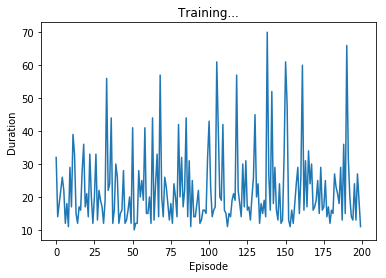

In [9]:
env = gym.make('CartPole-v0')
qlearner = QLearner(env)

qlearner.train(nb_episodes=200)
qlearner.printQ()
plt.figure(2)
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(qlearner.episode_durations)

In [10]:
qlearner.run()

old q is  27.4596317177
max q is  27.4596317177
R is  1.0
new_q is: 27.5321720859
old q is  27.5321720859
max q is  27.6046496404
R is  1.0
new_q is: 27.6118151918
old q is  27.6046496404
max q is  27.7013454783
R is  1.0
new_q is: 27.6866178787
old q is  27.7013454783
max q is  27.7013454783
R is  1.0
new_q is: 27.7736441329
old q is  27.7736441329
max q is  27.7736441329
R is  1.0
new_q is: 27.8458704887
old q is  27.8458704887
max q is  27.8458704887
R is  1.0
new_q is: 27.9180246182
old q is  27.9180246182
max q is  27.9180246182
R is  1.0
new_q is: 27.9901065936
old q is  27.9901065936
max q is  27.9901065936
R is  1.0
new_q is: 28.062116487
('Total Reward: ', 8.0)


In [1]:
learner = QLearner(env)
learner.train()
learner.run()

NameError: name 'QLearner' is not defined